In [1]:
import propagation_methods as propag
import grid_generation as grid
import bounds_common as bounds
import barriers as barriers
import probability_mass_computation as proba
import plot_methods as plot

import numpy as np

### **The polynomial case** 

In this experiement, $x_0$ follows a Gaussian distribution ($x_0 \sim \mathcal{N}(\mu_{0}, \Sigma_{0})$), and the system is polynomial following XXX.

We aim to compute GMM approximations $\hat{p}(x_t)$ for $5$ time steps, as well as bounds on their TV distances to the true distributions $p(x_t)$.

**Numerical note**: The theory related to this experiement does NOT demand that those Gaussians should have uncorrelated components. However, our current code implementation does assume that.

##### 1) Defining system parameters

In [2]:
METHOD = 'polynomial'

h = 0.1

params = [h]

In [3]:
#Initial distribution
sigma = 0.001

mean_initial_state = np.array([0.5, 3.0])
var_initial_state = np.array([sigma, sigma]) #Assumes uncorrelation (this could be relaxed in further upgrades)

#Noise structure
sigma_noise = 0.0001

mean_noise = [0, 0]
var_noise = np.array([sigma_noise, sigma_noise]) #Assumes uncorrelation (this could be relaxed in further upgrades)

#Steps ahead for prediction
n_steps_ahead = 8

In [4]:
unbounded_region = np.array([[np.inf, np.inf], [np.inf, np.inf]]) #a representation choice for the unbounded region

In [5]:
colors = ['Purples', 'Blues', 'Oranges', 'YlOrBr', 'YlOrRd', 
          'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 
          'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

##### 2) Monte Carlo simulation of the system

We run a MC simulation for the system above in order to understand its (probabilistic) behavior.

Note: We also add a representation for an unsafe set (red square) which will later motivate safety discussions.

In [6]:
barriers_list = barriers.createBarrier(np.array([[1.5, 1.0], [2.0, 1.5]]))
barrier = barriers_list[0]

Hitting proba: 0.0
Hitting proba: 0.0
Hitting proba: 0.0
Hitting proba: 0.0
Hitting proba: 0.0
Hitting proba: 0.0305
Hitting proba: 0.9998
Hitting proba: 0.7356
Hitting proba: 0.0253


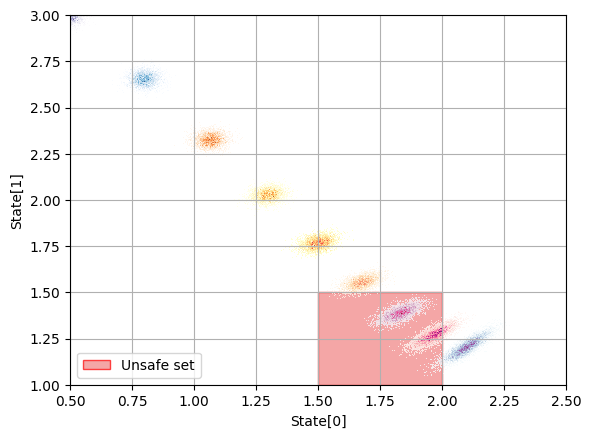

In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

n_simulations = 10000
mc_hitting_proba = []

fig, ax = plt.subplots()

rect = Rectangle(barrier[0], barrier[1][0] - barrier[0][0], barrier[1][1] - barrier[0][1], 
                    edgecolor = 'red', facecolor = 'lightcoral', fill=True, lw=1, alpha=0.7, label = 'Unsafe set')
ax.add_patch(rect)

for t in range(n_steps_ahead + 1):
    if t == 0:
        states = propag.getInitialState(mean_initial_state, var_initial_state, n_simulations)
    else:
        states = propag.stateOneStepEvolution(states, mean_noise, var_noise, METHOD, params)
    
    #Plot samples
    plt.hist2d(states[:, 0], states[:, 1], bins=100, cmap=colors[t], alpha=0.8, cmin=0.1)

    #Compute hitting probability
    hitting_proba = barriers.hittingProbabilityMC(states, barrier)
    mc_hitting_proba.append(hitting_proba)

plt.legend(loc='lower left')

plt.xlim(0.5, 2.5)
plt.ylim(1.0, 3.0)
plt.xlabel('State[0]')
plt.ylabel('State[1]')
plt.grid(True)
plt.show()

In [8]:
#Simulation settings
type_partition = 'unequally_linear'  #Options: unequally_linear or equally
tv_bounds = [0.0]
gmm_hitting_proba = [0.0]
n_partitions = [200, 200] #NOT BEING USED FOR THE UNEQUALLY LINEAR, SEE HACKING IN THE GRID FILE
n_sampling_gmm = 5000

vertice_lower_1 = [mean_initial_state[0] - 4*var_initial_state[0]**0.5, mean_initial_state[1] - 4*var_initial_state[1]**0.5]
vertice_upper_1 = [mean_initial_state[0] + 4*var_initial_state[0]**0.5, mean_initial_state[1] + 4*var_initial_state[1]**0.5]

Number of signatures: 52441
Function 'computeSignatureProbabilitiesInParallel' executed in 0.9006s
TV bound at propag step: 0.030486750999605836
0.0
Number of signatures: 52441
Function 'computeSignatureProbabilitiesInParallel' executed in 182.3737s
TV bound at propag step: 0.030261043873075946
0.0
Number of signatures: 52441
Function 'computeSignatureProbabilitiesInParallel' executed in 174.1250s
TV bound at propag step: 0.03015007103099664
0.0
Number of signatures: 52441
Function 'computeSignatureProbabilitiesInParallel' executed in 177.8416s
TV bound at propag step: 0.03187129989421425
0.0
Number of signatures: 52441
Function 'computeSignatureProbabilitiesInParallel' executed in 180.4049s
TV bound at propag step: 0.03317129235568823
0.028409569053119147
Number of signatures: 52441
Function 'computeSignatureProbabilitiesInParallel' executed in 181.2465s
TV bound at propag step: 0.03648912222280323
0.9993881836843701
Number of signatures: 52441
Function 'computeSignatureProbabilitiesI

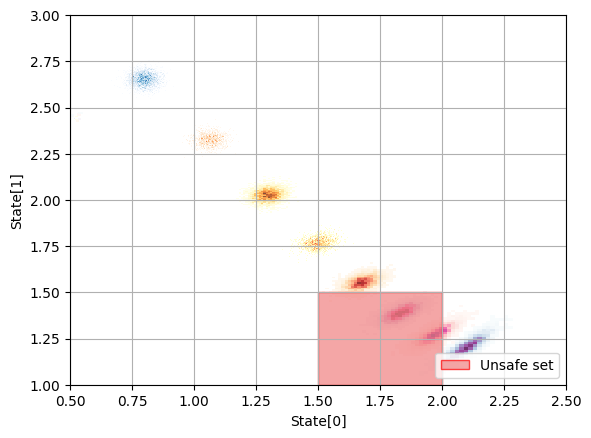

In [9]:
fig, ax = plt.subplots()

for t in range(n_steps_ahead + 1):
    if t == 0:
        hpr_1 = np.array([vertice_lower_1, vertice_upper_1])
        outer_signature = grid.compute_outer_point([hpr_1], 0.5)
        regions = grid.createRegionPartitions(hpr_1, n_partitions, type_partition)
        signatures = grid.placeSignatures(regions)
        double_hat_proba = proba.computeSignatureProbabilitiesInParallel(regions, np.array([mean_initial_state]), var_initial_state, np.array([1.0]))
        regions, signatures = grid.addUnboundedRepresentations(regions, unbounded_region, signatures, outer_signature)
    
    else:

        tv_bound = bounds.computeUpperBoundForTVWithMax(signatures, regions, double_hat_proba, var_noise, METHOD, params)
        tv_bounds.append(tv_bound)

        means_gmm = propag.propagateSignatures(signatures, METHOD, params)
        samples = propag.sampleFromGMM(n_sampling_gmm, double_hat_proba, means_gmm, var_noise)

        #Compute hitting probability
        proba_barrier = proba.gmmProbabilityMassInsideRegion(double_hat_proba, means_gmm, var_noise, barrier)
        gmm_hitting_proba.append(proba_barrier)

        plt.hist2d(samples[:, 0], samples[:, 1], bins=100, cmap=colors[t], alpha=0.8, cmin=0.1)

        signatures, regions = grid.updateGrid(samples, n_partitions, type_partition)
        double_hat_proba = proba.computeSignatureProbabilitiesInParallel(regions, means_gmm, var_noise, double_hat_proba)
        regions, signatures = grid.addUnboundedRepresentations(regions, unbounded_region, signatures, outer_signature)



rect = Rectangle(barrier[0], barrier[1][0] - barrier[0][0], barrier[1][1] - barrier[0][1], 
                    edgecolor = 'red', facecolor = 'lightcoral', fill=True, lw=1, alpha=0.7, label = 'Unsafe set')
ax.add_patch(rect)

plt.legend(loc='lower left')

plt.xlim(0.5, 2.5)
plt.ylim(1.0, 3.0)
plt.xlabel('State[0]')
plt.ylabel('State[1]')
plt.grid(True)
plt.show()

##### Compare hitting probabilities

C:\Users\efigueiredomot\AppData\Local\Temp\ipykernel_14132\2550381539.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


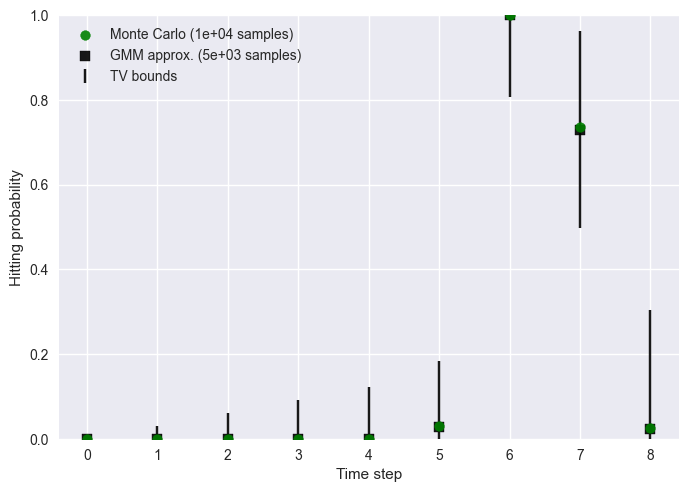

In [10]:
#Compute TV bounds
tv_bounds_cumul = np.cumsum(tv_bounds)

plt.style.use("seaborn")

# Plotting
plt.scatter(range(len(mc_hitting_proba)), mc_hitting_proba, color='green', alpha = 0.9, label = f'Monte Carlo ({n_simulations:.0e} samples)', zorder=3)
plt.scatter(range(len(gmm_hitting_proba)), gmm_hitting_proba, color='black', alpha = 0.9, marker='s', label = f'GMM approx. ({n_sampling_gmm:.0e} samples)', zorder=2)

# Adding error bars for gmm_probas
plt.errorbar(range(len(gmm_hitting_proba)), gmm_hitting_proba, yerr = tv_bounds_cumul, fmt='none', color='black', alpha = 0.9, capsize=5, label='TV bounds', zorder=1)

plt.ylim(0, 1)
plt.xticks(range(len(mc_hitting_proba)))

plt.xlabel('Time step')
plt.ylabel('Hitting probability')
plt.legend()
plt.show()